# short position + long call position
https://aaronschlegel.me/black-scholes-formula-python.html

In [1]:
import math
import numpy as np
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt

import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing
init_printing()

# option pricing functions

In [2]:
def euro_vanilla_call(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

def euro_vanilla_call_delta(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    return si.norm.cdf(d1, 0.0, 1.0)

def euro_vanilla_put(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    
    return put

def euro_vanilla_put_delta(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    return euro_vanilla_call_delta(S, K, T, r, sigma) - 1

In [3]:
print('call = ', euro_vanilla_call(50, 100, 1, 0.05, 0.25))
print('put = ', euro_vanilla_put(50, 100, 1, 0.05, 0.25))

call =  0.027352509369436617
put =  45.15029495944084


# plot valuations of portfolios

In [4]:
def plot_portfolio_value(S, price_range, get_portfolio_value, title, K=None): 
    """plot portfolio value over a range of prices"""
    portfolio_value = [get_portfolio_value(p) for p in price_range] 
    plt.figure(figsize=(18,6))
    plt.plot(price_range, portfolio_value, 'bo-')
    if not K == None:
        if isinstance(K, list):
            for k in K:
                plt.plot([k,k],[min(portfolio_value)-5, max(portfolio_value)+5], '-', color='orange')
        else:
            plt.plot([K,K],[min(portfolio_value)-5, max(portfolio_value)+5], '-', color='orange')
    plt.plot(S, get_portfolio_value(S), 'o', color='red', markersize=10)
    plt.title(title)
    plt.xlabel('stock price')
    plt.ylabel('portfolio value')
    plt.show()

delta = 0.8883


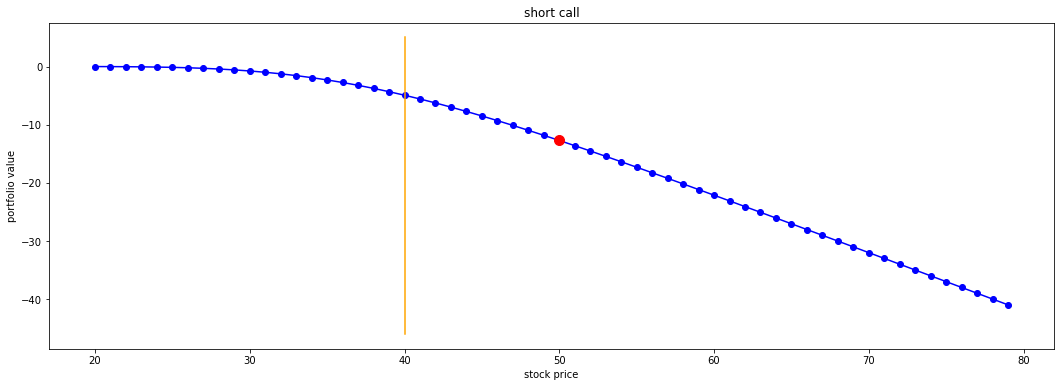

In [5]:
class call_option_portfolio():
    
    def __init__(self, S, K, T, r, sigma):
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.delta = euro_vanilla_call_delta(S, K, T, r, sigma)
        print(f'delta = {self.delta:0.4}')
         
    def value(self, S):
        short_position = -S
        call_price =  euro_vanilla_call(S, self.K, self.T, self.r, self.sigma)
        return -call_price 

S, K, T, r, sigma = 50, 40, 1, 0.05, 0.25
    
short_call = call_option_portfolio(S, K, T, r, sigma)
plot_portfolio_value(S, np.arange(20,80,1), short_call.value, 'short call', K)

delta = 0.8883


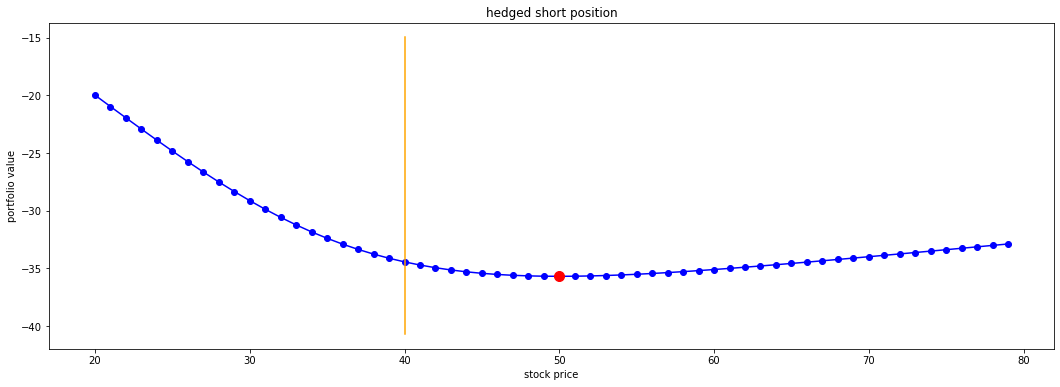

In [6]:
class hedged_short_portfolio():
    """
    short the stock
    long a delta adjusted call
    """
    def __init__(self, S, K, T, r, sigma, delta=None):
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        if delta == None:
            self.delta = euro_vanilla_call_delta(S, K, T, r, sigma)
        else:
            self.delta = delta
        print(f'delta = {self.delta:0.4}')
        self.current_S = S
        self.current_value = self.value(S)
         
    def value(self, S):
        short_position = -S
        call_price =  euro_vanilla_call(S, self.K, self.T, self.r, self.sigma)
        return short_position + call_price / self.delta
    
    def p_l(self, S):
        return self.value(S) - self.current_value
    
S, K, T, r, sigma = 50, 40, 1, 0.05, 0.25
    
hp = hedged_short_portfolio(S, K, T, r, sigma)
plot_portfolio_value(S, np.arange(20,80,1), hp.value, 'hedged short position', K)

# historical simulation of AAPL prices

In [7]:
from math import log, exp
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from IPython.display import display
import matplotlib.pyplot as plt

tickers = ['AAPL']

tickers_df = yf.download(tickers, 
                      start='2017-01-01', 
                      end='2020-11-20', 
                      progress=False, auto_adjust=True)
display(tickers_df.head())
display(tickers_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,27.250104,27.374824,27.005371,27.332466,115127600
2017-01-04,27.261878,27.417190,27.238346,27.301882,84472400
2017-01-05,27.278350,27.499552,27.252464,27.440722,88774400
2017-01-06,27.480722,27.805466,27.407773,27.746635,127007600
2017-01-09,27.756043,28.104318,27.753691,28.000776,134247600


,Open,High,Low,Close,Volume
Date,,,,,
2020-11-13,118.708202,118.936789,117.147822,118.529305,81581900
2020-11-16,118.191370,120.248687,117.426091,119.562920,91183000
2020-11-17,118.817516,119.930649,118.231127,118.658493,74271000
2020-11-18,117.883272,119.085857,117.277009,117.306824,76322100
2020-11-19,116.869516,118.330511,116.094297,117.913086,74113000


closing price = 117.9131
range of daily returns: -0.1377 to 0.1132
range of simulated prices: 102.7439 to 132.0400


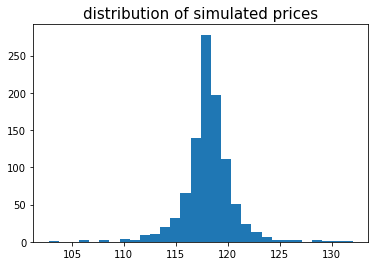

In [8]:
closing_price = tickers_df['Close'][-1]
print(f"closing price = {closing_price:0.4f}")
returns = tickers_df['Close'].apply(log).diff()[1:]
historical_sim_prices = returns.apply(exp) * closing_price
print(f"range of daily returns: {min(returns):0.4f} to {max(returns):0.4f}")
print(f"range of simulated prices: {min(historical_sim_prices):0.4f} to {max(historical_sim_prices):0.4f}")

plt.hist(historical_sim_prices,30)
plt.title("distribution of simulated prices", fontsize=15)
plt.show()

# create a portfolio and reprice it based on the historical returns
## strike, term, r, sigma = 118, 1 month, 0, annualized vol

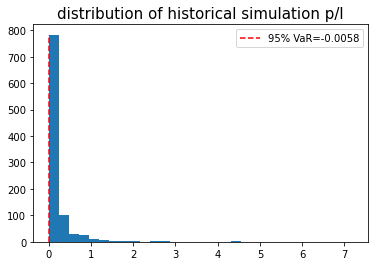

95% VaR is 0.0058


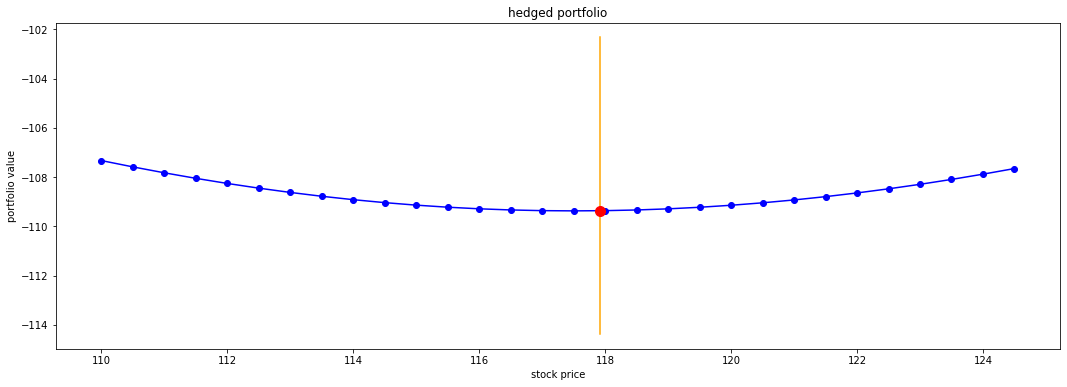

In [9]:
class option_portfolio():
    """short position hedged by a long call"""
    def __init__(self, S, K, T, r, sigma):
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.current_S = S
        self.current_value = self.value(S)
         
    def value(self, S):
        short_position = -S
        call_price =  2 * euro_vanilla_call(S, self.K, self.T, self.r, self.sigma)
        return short_position + call_price 
    
    def p_l(self, S):
        return self.value(S) - self.current_value

def calculate_VaR(port, historical_sim_prices):

    simulated_p_l =[port.p_l(p) for p in historical_sim_prices]
    VaR95 = np.quantile(simulated_p_l, .05)

    hist = plt.hist(simulated_p_l,30)
    max_freq = max(hist[0])

    plt.plot([VaR95,VaR95],[0,max_freq], '--', color='red', label=f"95% VaR={VaR95:0.4f}")
    plt.title("distribution of historical simulation p/l", fontsize=15)
    plt.legend()
    plt.show()
    
    if VaR95 < 0:
        print(f"95% VaR is {-VaR95:0.4f}")
    else:
        print(f"the 5% point in the distribution of returns is positive so, 95% Var = 0")
    
    
    return VaR95

S, K, T, r, sigma = closing_price, 118, 1/12, 0.0, np.std(returns) * np.sqrt(252)
op1 = option_portfolio(S, K, T, r, sigma)
VaR95 = calculate_VaR(op1, historical_sim_prices)

plot_portfolio_value(closing_price, np.arange(110,125,.5), op1.value, 'hedged portfolio', closing_price)

In [72]:

class aging_option_portfolio(option_portfolio):
    """short position hedged by a long call that decrements the time to maturity at each value call"""
    def __init__(self, S, K, T, r, sigma):
        super().__init__(S, K, T, r, sigma)

    def aging_value(self, S):
        x = self.value(S)
        self.T -= 5/252
        return x
            
S, K, T, r, sigma = closing_price, 118, 5, 0.0, np.std(returns) * np.sqrt(252)
op1 = option_portfolio(S, K, T, r, sigma)

print(op1.value(closing_price))
op1.T -= 5/252
print(op1.value(closing_price),'\n')

op1_aging = aging_option_portfolio(S, K, T, r, sigma)

print(op1_aging.aging_value(closing_price))
print(op1_aging.aging_value(closing_price))

-52.49144319878798
-52.616180167237815 

-52.49144319878798
-52.616180167237815


Date
2017-01-03    27.332466
2017-01-10    28.029022
2017-01-18    28.236101
2017-01-25    28.680859
2017-02-01    30.297514
Name: Close, dtype: float64

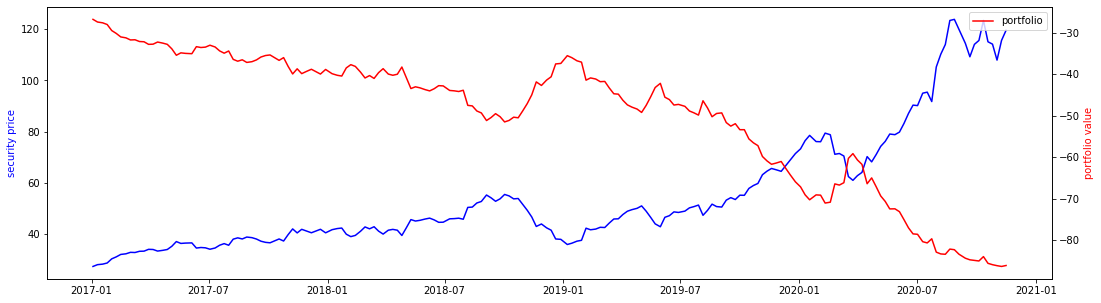

In [81]:

S, K, T, r, sigma = closing_price, 118, 5, 0.0, np.std(returns) * np.sqrt(252)
op1_aging = aging_option_portfolio(S, K, T, r, sigma)

price_history = tickers_df['Close'][::5]
display(price_history[:5])

fig, ax1 = plt.subplots(figsize=(18,5))
ax2 = ax1.twinx()

ax1.plot(price_history, label='security price', color='blue')
ax2.plot(price_history.index, [op1_aging.aging_value(price) for price in price_history], label='portfolio', color='red')

ax1.set_ylabel('security price', color='blue')
ax2.set_ylabel('portfolio value', color='red')
plt.legend()
plt.show()